# Diffusion processes on complex networks - assignment 1
### Mateusz Dzitkowski 249777

### Exercise 1
We are tasked with implementing three random graph generators, the code is displayed below 

In [54]:
from functools import partial
from itertools import combinations
from random import random, choice
from typing import Callable

from matplotlib import pyplot as plt
from networkx import Graph 
import networkx as nx
from nptyping import NDArray
import numpy as np
import scipy as sp

In [2]:
def erdos_renyi(number_of_nodes: int, edge_probability: float) -> Graph:
    assert 0 <= edge_probability <= 1
    assert number_of_nodes > 0

    g = Graph()
    g.add_nodes_from(range(number_of_nodes))

    for _from, _to in combinations(range(number_of_nodes), 2):
        if random() < edge_probability:
            g.add_edge(_from, _to)

    return g

In [3]:
def watts_strogatz(number_of_nodes: int, initial_neighbours: int, rewire_probability: float) -> Graph:
    assert 0 <= rewire_probability <= 1
    assert 0 < initial_neighbours <= number_of_nodes

    g = Graph()
    nodes = list(range(number_of_nodes))

    # initial edges
    for j in range(1, initial_neighbours // 2 + 1):
        targets = nodes[j:] + nodes[0:j]
        g.add_edges_from(zip(nodes, targets))

    # rewired edges
    for j in range(1, initial_neighbours // 2 + 1):
        targets = nodes[j:] + nodes[0:j]
        for u, v in zip(nodes, targets):
            if random() > rewire_probability:
                continue

            w = choice(nodes)
            while w == u or g.has_edge(u, w):
                w = choice(nodes)
                if g.degree(u) >= number_of_nodes - 1:
                    break
            else:
                g.remove_edge(u, v)
                g.add_edge(u, w)
    return g


In [120]:
def _random_subset(seq: list, m: int):
    targets = set()
    while len(targets) < m:
        targets.add(choice(seq))
    return targets

def barabasi_albert(number_of_nodes: int, edges_attached: int) -> Graph:
    g = nx.star_graph(edges_attached)
    assert 1 <= edges_attached < number_of_nodes
    assert edges_attached <= len(g) <= number_of_nodes

    nodes_weighted = [node for node, degree in g.degree() for _ in range(degree)]

    source = len(g)
    while source < number_of_nodes:
        targets = _random_subset(nodes_weighted, edges_attached)
        g.add_edges_from(zip([source] * edges_attached, targets))
        nodes_weighted.extend(list(targets) + [source] * edges_attached)
        source += 1

    return g


In [60]:
def degrees(g: Graph) -> NDArray:
    return np.array([item[1] for item in g.degree()])

def plot_hist_and_expected_density(g: Graph, density: Callable):
    d = degrees(g)
    x = np.arange(d.min(), d.max(), step=1)
    plt.hist(d, bins=50, density=True)
    plt.plot(x, density(x))

Let's investigate the first, Erdos-Renyi, graph. We will generate a graph for various amount of parameters, compute some statistics, and fit a model distribution to the degree data.

In [26]:
N = 2000
p = np.arange(0.05, 1, step=0.05)
graphs = [erdos_renyi(N, _p) for _p in p]

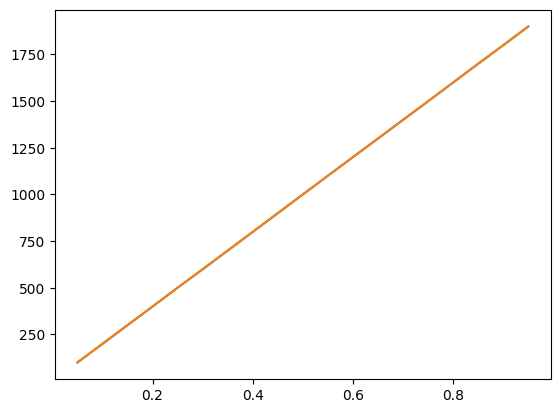

In [27]:
plt.plot(p, [degrees(g).mean() for g in graphs])
plt.plot(p, (N - 1) * p)

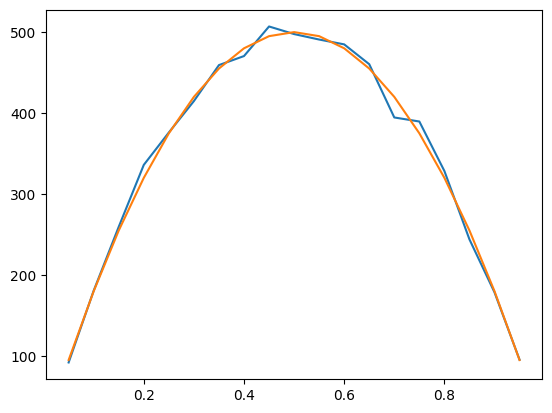

In [28]:
plt.plot(p, [degrees(g).var() for g in graphs])
plt.plot(p, p*(1-p)*N)

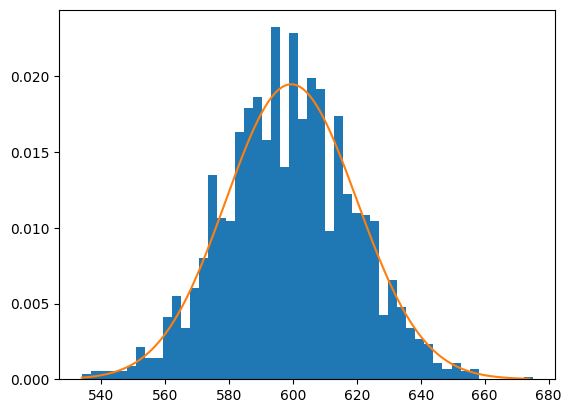

In [71]:
index = 5
_p = p[index]
plot_hist_and_expected_density(graphs[index], partial(sp.stats.binom.pmf, n=N-1, p=_p))

In [81]:
index = 1
_p = p[index]
print(f"True values: {N=}, {_p=}")
sp.stats.fit(
    sp.stats.binom,
    degrees(graphs[index]),
    bounds=[(1900, 2100), (0, 1)],
).params

True values: N=2000, _p=0.1


FitParams(n=1927.0, p=0.0020757604388969854, loc=0.0)

Watts-Strogatz

In [92]:
N = 2000
m = np.array([2, 4, 10, 20])
p = np.arange(0.05, 1, step=0.05)
graphs = [[watts_strogatz(N, _m, _p) for _p in p] for _m in m]

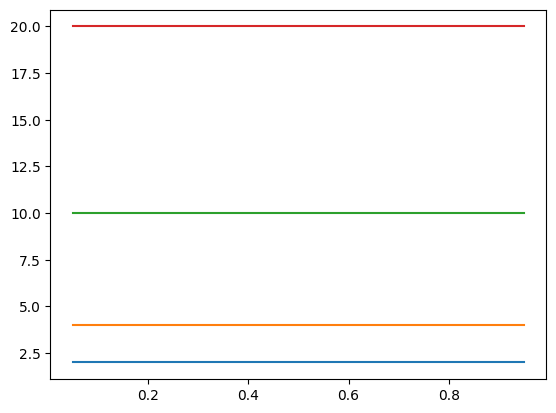

In [100]:
for row in graphs:
    plt.plot(p, [degrees(g).mean() for g in row])

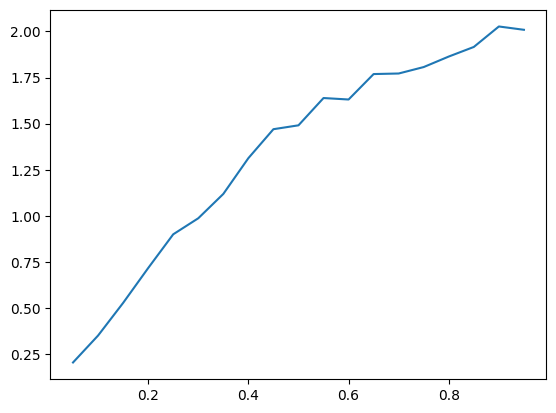

In [89]:
plt.plot(p, [degrees(g).var() for g in graphs])

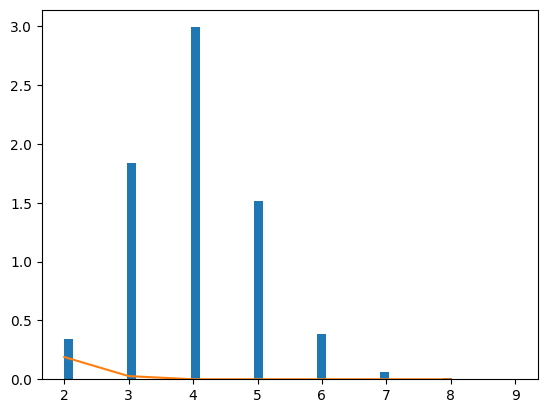

In [104]:
i, j = 1, 5
_p = p[j]
plot_hist_and_expected_density(graphs[i][j], partial(sp.stats.binom.pmf, n=m[i]-1, p=_p))

Barbasi-Albert model

In [126]:
N = 2000
m = np.arange(1, 30, 1)
graphs = [barabasi_albert(N, _m) for _m in m]

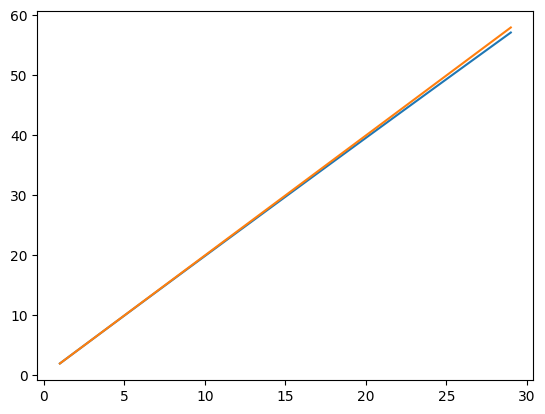

In [122]:
plt.plot(m, [degrees(g).mean() for g in graphs])
plt.plot(m, 2*m)

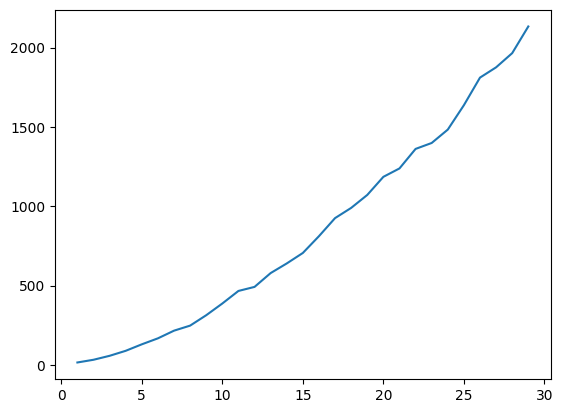

In [129]:
plt.plot(m, [degrees(g).var() for g in graphs])